In [3]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [88]:
import seaborn as sns
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings('ignore')

from matplotlib import pylab as plt
import numpy as np
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM, GRU, SimpleRNN
from keras.layers import LSTM, GRU
from tensorflow import keras
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [89]:
csv_path = '/content/drive/MyDrive/DeepLearning/RNN/Turbine_Data.csv'
df = pd.read_csv(csv_path, parse_dates = True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 118224 entries, 0 to 118223
Data columns (total 22 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   Unnamed: 0                    118224 non-null  object 
 1   ActivePower                   94750 non-null   float64
 2   AmbientTemperatue             93817 non-null   float64
 3   BearingShaftTemperature       62518 non-null   float64
 4   Blade1PitchAngle              41996 non-null   float64
 5   Blade2PitchAngle              41891 non-null   float64
 6   Blade3PitchAngle              41891 non-null   float64
 7   ControlBoxTemperature         62160 non-null   float64
 8   GearboxBearingTemperature     62540 non-null   float64
 9   GearboxOilTemperature         62438 non-null   float64
 10  GeneratorRPM                  62295 non-null   float64
 11  GeneratorWinding1Temperature  62427 non-null   float64
 12  GeneratorWinding2Temperature  62449 non-null

In [90]:
df = df.rename(columns={'Unnamed: 0': 'Datetime'})
df.index = pd.to_datetime(df.Datetime) 
df.drop(['Datetime'], axis=1, inplace=True)

df.head()

,ActivePower,AmbientTemperatue,BearingShaftTemperature,Blade1PitchAngle,Blade2PitchAngle,Blade3PitchAngle,ControlBoxTemperature,GearboxBearingTemperature,GearboxOilTemperature,GeneratorRPM,GeneratorWinding1Temperature,GeneratorWinding2Temperature,HubTemperature,MainBoxTemperature,NacellePosition,ReactivePower,RotorRPM,TurbineStatus,WTG,WindDirection,WindSpeed
Datetime,,,,,,,,,,,,,,,,,,,,,
2017-12-31 00:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,G01,NaN,NaN
2017-12-31 00:10:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,G01,NaN,NaN
2017-12-31 00:20:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,G01,NaN,NaN
2017-12-31 00:30:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,G01,NaN,NaN
2017-12-31 00:40:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,G01,NaN,NaN


In [91]:
df.describe()

,ActivePower,AmbientTemperatue,BearingShaftTemperature,Blade1PitchAngle,Blade2PitchAngle,Blade3PitchAngle,ControlBoxTemperature,GearboxBearingTemperature,GearboxOilTemperature,GeneratorRPM,GeneratorWinding1Temperature,GeneratorWinding2Temperature,HubTemperature,MainBoxTemperature,NacellePosition,ReactivePower,RotorRPM,TurbineStatus,WindDirection,WindSpeed
count,94750.000000,93817.000000,62518.000000,41996.000000,41891.000000,41891.000000,62160.0,62540.000000,62438.000000,62295.000000,62427.000000,62449.000000,62406.000000,62507.000000,72278.000000,94748.000000,62127.000000,6.290800e+04,72278.000000,94595.000000
mean,619.109805,28.774654,43.010189,9.749641,10.036535,10.036535,0.0,64.234170,57.561217,1102.026269,72.460403,71.826659,36.897978,39.547603,196.290539,88.133966,9.907500,2.280429e+03,196.290539,5.878960
std,611.275373,4.369145,5.545312,20.644828,20.270465,20.270465,0.0,10.455556,6.323895,528.063946,22.627489,22.650255,5.178711,5.732783,88.296554,116.596725,4.718421,3.586034e+05,88.296554,2.619084
min,-38.524659,0.000000,0.000000,-43.156734,-26.443415,-26.443415,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-203.182591,0.000000,0.000000e+00,0.000000,0.000000
25%,79.642258,25.627428,39.840247,-0.939849,-0.433264,-0.433264,0.0,57.872242,53.942181,1029.812177,55.492241,54.763998,33.943949,35.812500,145.000000,-0.432137,9.231091,2.000000e+00,145.000000,3.823330
50%,402.654893,28.340541,42.910877,0.394399,0.888977,0.888977,0.0,64.834662,57.196089,1124.860720,65.788800,65.004946,37.003815,39.491310,182.000000,35.883659,10.098702,2.000000e+00,182.000000,5.557765
75%,1074.591780,31.664772,47.007976,8.099302,8.480194,8.480194,0.0,71.079306,61.305312,1515.402005,85.867449,85.337740,40.008425,43.359375,271.000000,147.359075,13.600413,2.000000e+00,271.000000,7.506710
max,1779.032433,42.405597,55.088655,90.143610,90.017830,90.017830,0.0,82.237932,70.764581,1809.941700,126.773031,126.043018,47.996185,54.250000,357.000000,403.713620,16.273495,6.574653e+07,357.000000,22.970893


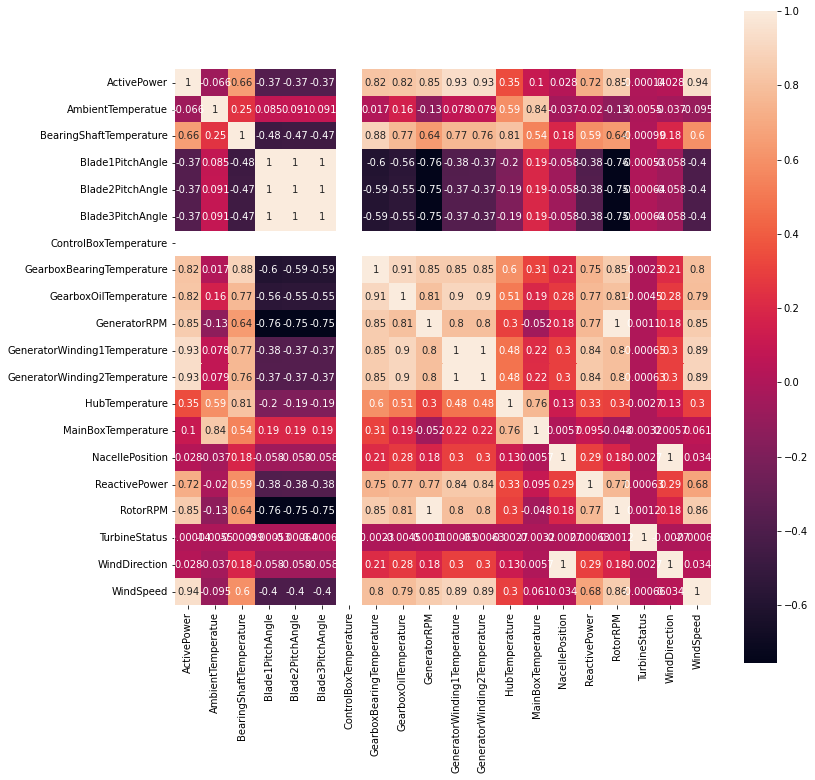

In [92]:
plt.subplots(figsize=(12, 12))
sns.heatmap(df.corr(), annot=True, square=True)

In [93]:
## A correlação das colunas Blade1PitchAngle, Blade2PitchAngle e Blade3PitchAngle e fraca se comparado ao restante das outras colunas.
## Ha tambem alguns valores nos quais podem atrapalhar o modelo devido a correlacao muito alta com features semelhantes

df.drop(['Blade1PitchAngle', 'Blade2PitchAngle', 'Blade3PitchAngle', 'ControlBoxTemperature', 'TurbineStatus', 'AmbientTemperatue', 'WTG', 'NacellePosition'], axis=1, inplace=True)

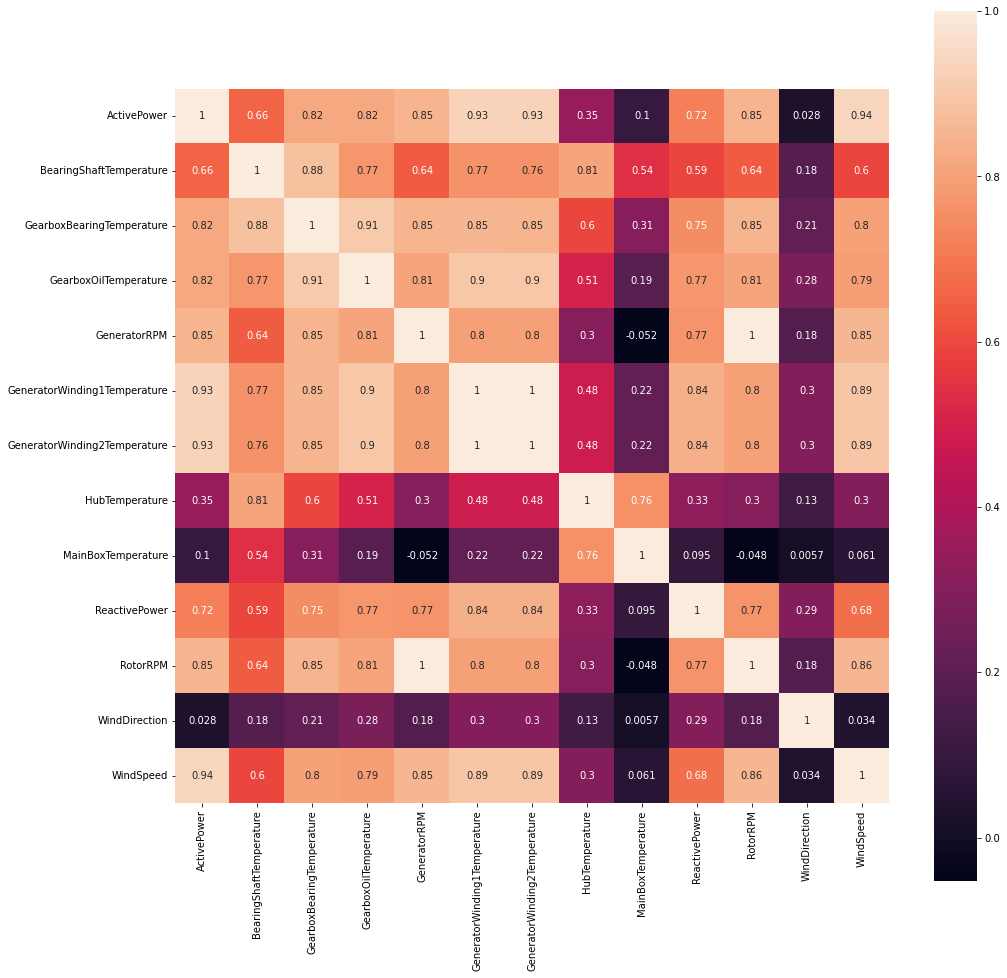

In [94]:
plt.subplots(figsize=(16, 16))
sns.heatmap(df.corr(), annot=True, square=True)

In [95]:
df.describe()

,ActivePower,BearingShaftTemperature,GearboxBearingTemperature,GearboxOilTemperature,GeneratorRPM,GeneratorWinding1Temperature,GeneratorWinding2Temperature,HubTemperature,MainBoxTemperature,ReactivePower,RotorRPM,WindDirection,WindSpeed
count,94750.000000,62518.000000,62540.000000,62438.000000,62295.000000,62427.000000,62449.000000,62406.000000,62507.000000,94748.000000,62127.000000,72278.000000,94595.000000
mean,619.109805,43.010189,64.234170,57.561217,1102.026269,72.460403,71.826659,36.897978,39.547603,88.133966,9.907500,196.290539,5.878960
std,611.275373,5.545312,10.455556,6.323895,528.063946,22.627489,22.650255,5.178711,5.732783,116.596725,4.718421,88.296554,2.619084
min,-38.524659,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-203.182591,0.000000,0.000000,0.000000
25%,79.642258,39.840247,57.872242,53.942181,1029.812177,55.492241,54.763998,33.943949,35.812500,-0.432137,9.231091,145.000000,3.823330
50%,402.654893,42.910877,64.834662,57.196089,1124.860720,65.788800,65.004946,37.003815,39.491310,35.883659,10.098702,182.000000,5.557765
75%,1074.591780,47.007976,71.079306,61.305312,1515.402005,85.867449,85.337740,40.008425,43.359375,147.359075,13.600413,271.000000,7.506710
max,1779.032433,55.088655,82.237932,70.764581,1809.941700,126.773031,126.043018,47.996185,54.250000,403.713620,16.273495,357.000000,22.970893


No handles with labels found to put in legend.


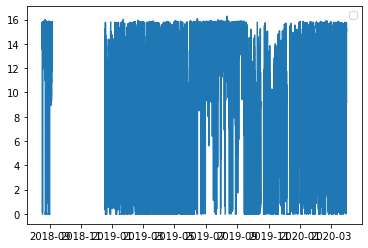

In [96]:
plt.plot(df["RotorRPM"])
plt.legend()
plt.show()

In [97]:
## Apos ver a distribuicao dos dados da feture ActivePower, NacellePosition, WindSpeed percebo que para ha NaN entao prefiro remover eles
df = df.dropna(subset=['ActivePower', 'WindSpeed'])

## Fazer um teste removendo os nan  das colunas abaixo

## Preencho o lack de informacao da feature BearingShaftTemperature,GearboxBearingTemperature,GearboxOilTemperature, GeneratorRPM, GeneratorWinding1Temperature, GeneratorWinding2Temperature, 
## HubTemperature, MainBoxTemperature, RotorRPM, ReactivePower, WindDirection, WindSpeed com 0
df = df.fillna(0)

df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 94436 entries, 2018-01-01 00:00:00+00:00 to 2020-03-30 23:50:00+00:00
Data columns (total 13 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   ActivePower                   94436 non-null  float64
 1   BearingShaftTemperature       94436 non-null  float64
 2   GearboxBearingTemperature     94436 non-null  float64
 3   GearboxOilTemperature         94436 non-null  float64
 4   GeneratorRPM                  94436 non-null  float64
 5   GeneratorWinding1Temperature  94436 non-null  float64
 6   GeneratorWinding2Temperature  94436 non-null  float64
 7   HubTemperature                94436 non-null  float64
 8   MainBoxTemperature            94436 non-null  float64
 9   ReactivePower                 94436 non-null  float64
 10  RotorRPM                      94436 non-null  float64
 11  WindDirection                 94436 non-null  float64
 12  WindSpeed    

In [98]:
df_processed = df

## Separação dos dados em treinamento/teste/validação

In [100]:
mask = (df_processed.index < pd.to_datetime("2020-02-28 00:00:00").tz_localize('US/Eastern'))
training_data = df_processed.loc[mask]

print (len(training_data))

val_mask = (df_processed.index >= pd.to_datetime("2020-03-01").tz_localize('US/Eastern')) & (df_processed.index <= pd.to_datetime("2020-03-15").tz_localize('US/Eastern'))
val_data = df_processed.loc[val_mask]



test_mask = (df_processed.index > pd.to_datetime("2020-03-15").tz_localize('US/Eastern'))
test_data = df_processed.loc[test_mask]



89874


## Normalização dos dados. 

In [101]:
column_training = ['BearingShaftTemperature', 'GearboxBearingTemperature', 'GearboxOilTemperature', 'GeneratorRPM', 'GeneratorWinding1Temperature', 'GeneratorWinding2Temperature', 'HubTemperature', 'MainBoxTemperature', 'ReactivePower', 'RotorRPM', 'WindDirection', 'WindSpeed', 'ActivePower']

x_train = training_data[column_training]

x_val = val_data[column_training]

x_test = test_data[column_training]

In [102]:
scaler = MinMaxScaler().fit(x_train)

xtrain_norm = scaler.transform(x_train)
xval_norm = scaler.transform(x_val)
xtest_norm = scaler.transform(x_test)

y_train_final = xtrain_norm[:,:1]
x_train_final = xtrain_norm[:,1:]

y_val_final = xval_norm[:,:1]
x_val_final = xval_norm[:,1:]

y_test_final = xtest_norm[:,:1]
x_test_final = xtest_norm[:,1:]

## Preparacao do dataset para treinamento

In [18]:
batch_size = 128
window_length = 15

#input_data = x_train_final[:-window_length]
targets = y_train_final[window_length:]
dataset_train = keras.preprocessing.timeseries_dataset_from_array(
    x_train_final, targets, sequence_length=window_length, batch_size=batch_size)

#input_data = x_val_final[:-window_length]
targets = y_val_final[window_length:]
dataset_val = keras.preprocessing.timeseries_dataset_from_array(
    x_val_final, targets, sequence_length=window_length, batch_size=batch_size)

#input_data = x_test_final[:-1]
targets = y_test_final[window_length:]
dataset_test = keras.preprocessing.timeseries_dataset_from_array(
    x_test_final, targets, sequence_length=window_length, batch_size=batch_size)

print(x_train_final.shape)
print(y_train_final.shape)


(89874, 12)
(89874, 1)


## Teste com GRU

In [19]:
def metrics(model_train):
  yhat = model_train.predict(dataset_test)

  inv_yhat = np.concatenate((yhat, x_test_final[window_length:][:, -12:]), axis=1)
  inv_yhat = scaler.inverse_transform(inv_yhat)
  inv_yhat = inv_yhat[:,0]

  # invert scaling for actual
  inv_y = np.concatenate((y_test_final[window_length:], x_test_final[window_length:][:, -12:]), axis=1)
  inv_y = scaler.inverse_transform(inv_y)
  inv_y = inv_y[:,0]

  rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
  print('Test RMSE: %.3f' % rmse)

  mse = mean_squared_error(inv_y, inv_yhat)
  print('Test MSE: %.3f' % mse)

  mae = mean_absolute_error(inv_y, inv_yhat)
  print('Test MAE: %.3f' % mae)

  return inv_y, rmse, mse, mae

In [29]:
model_k = Sequential()
model_k.add(GRU(32, input_shape=(window_length,12), return_sequences=True))
model_k.add(Dropout(0.2))

model_k.add(GRU(64, input_shape=(window_length,12)))
model_k.add(Dropout(0.2))

model_k.add(Dense(1, activation='linear'))

# opt = keras.optimizers.SGD(learning_rate=0.001)
opt = keras.optimizers.Adam(learning_rate=0.001)
model_k.compile(loss='mse', optimizer=opt)
model_k.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_5 (GRU)                 (None, 15, 32)            4416      
                                                                 
 dropout_5 (Dropout)         (None, 15, 32)            0         
                                                                 
 gru_6 (GRU)                 (None, 64)                18816     
                                                                 
 dropout_6 (Dropout)         (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 23,297
Trainable params: 23,297
Non-trainable params: 0
_________________________________________________________________


In [30]:
history = model_k.fit(dataset_train, validation_data=dataset_val,epochs=20)

Epoch 1/20
703/703 [==============================] - 31s 39ms/step - loss: 0.0109 - val_loss: 0.0027
Epoch 2/20
703/703 [==============================] - 26s 38ms/step - loss: 0.0064 - val_loss: 0.0023
Epoch 3/20
703/703 [==============================] - 27s 38ms/step - loss: 0.0059 - val_loss: 0.0022
Epoch 4/20
703/703 [==============================] - 27s 38ms/step - loss: 0.0057 - val_loss: 0.0025
Epoch 5/20
703/703 [==============================] - 27s 39ms/step - loss: 0.0055 - val_loss: 0.0027
Epoch 6/20
703/703 [==============================] - 27s 38ms/step - loss: 0.0053 - val_loss: 0.0024
Epoch 7/20
703/703 [==============================] - 27s 39ms/step - loss: 0.0052 - val_loss: 0.0026
Epoch 8/20
703/703 [==============================] - 27s 38ms/step - loss: 0.0051 - val_loss: 0.0025
Epoch 9/20
703/703 [==============================] - 27s 39ms/step - loss: 0.0050 - val_loss: 0.0028
Epoch 10/20
703/703 [==============================] - 27s 38ms/step - loss: 0.004

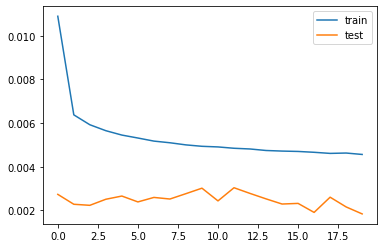

In [31]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()

In [34]:
res = model_k.evaluate(dataset_test)
print(res)

18/18 [==============================] - 1s 25ms/step - loss: 0.0041
0.0040776608511805534


Test RMSE: 3.518
Test MSE: 12.375
Test MAE: 1.992


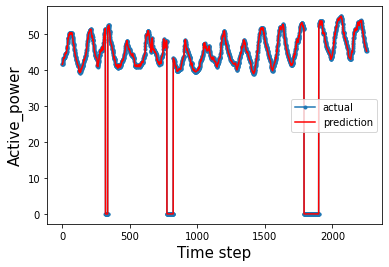

In [35]:
inv_y_r, rmse, mse, mae = metrics(model_k)

aa=[x for x in range(inv_y_r.shape[0])]
plt.plot(aa, inv_y_r[:inv_y_r.shape[0]], marker='.', label="actual")
plt.plot(aa, inv_y_r[:inv_y_r.shape[0]], 'r', label="prediction")
plt.ylabel('Active_power', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=10)
plt.show()

## Teste com LTSM

In [52]:
# The LSTM model I would like to test
# Note: replace LSTM with GRU or RNN if you want to try those

modelLSTM = Sequential()
modelLSTM.add(LSTM(64, input_shape=(window_length,12)))
modelLSTM.add(Dropout(0.2))

modelLSTM.add(Dense(1, activation = "linear"))

# opt = keras.optimizers.Adam(learning_rate=0.001)
opt = keras.optimizers.Adam(learning_rate=0.001)
modelLSTM.compile(loss='mae', optimizer=opt)

print (modelLSTM.summary())

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_7 (LSTM)               (None, 64)                19712     
                                                                 
 dropout_14 (Dropout)        (None, 64)                0         
                                                                 
 dense_8 (Dense)             (None, 1)                 65        
                                                                 
Total params: 19,777
Trainable params: 19,777
Non-trainable params: 0
_________________________________________________________________
None


In [53]:
historyLSTM = modelLSTM.fit(dataset_train, validation_data=dataset_val,epochs=20)

Epoch 1/20
703/703 [==============================] - 22s 29ms/step - loss: 0.0541 - val_loss: 0.0276
Epoch 2/20
703/703 [==============================] - 20s 28ms/step - loss: 0.0409 - val_loss: 0.0313
Epoch 3/20
703/703 [==============================] - 20s 28ms/step - loss: 0.0387 - val_loss: 0.0275
Epoch 4/20
703/703 [==============================] - 20s 29ms/step - loss: 0.0379 - val_loss: 0.0294
Epoch 5/20
703/703 [==============================] - 20s 28ms/step - loss: 0.0373 - val_loss: 0.0311
Epoch 6/20
703/703 [==============================] - 20s 28ms/step - loss: 0.0368 - val_loss: 0.0293
Epoch 7/20
703/703 [==============================] - 20s 29ms/step - loss: 0.0365 - val_loss: 0.0301
Epoch 8/20
703/703 [==============================] - 20s 29ms/step - loss: 0.0363 - val_loss: 0.0263
Epoch 9/20
703/703 [==============================] - 20s 28ms/step - loss: 0.0356 - val_loss: 0.0212
Epoch 10/20
703/703 [==============================] - 19s 28ms/step - loss: 0.035

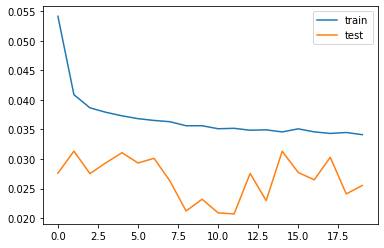

In [56]:
plt.plot(historyLSTM.history['loss'], label='train')
plt.plot(historyLSTM.history['val_loss'], label='test')
plt.legend()

Test RMSE: 3.682
Test MSE: 13.560
Test MAE: 2.238


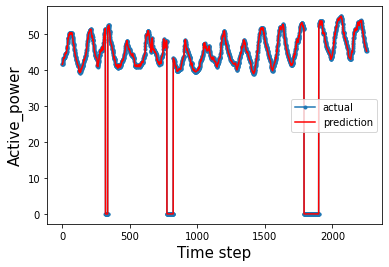

In [57]:
inv_y_r, rmse, mse, mae = metrics(modelLSTM)

aa=[x for x in range(inv_y_r.shape[0])]
plt.plot(aa, inv_y_r[:inv_y_r.shape[0]], marker='.', label="actual")
plt.plot(aa, inv_y_r[:inv_y_r.shape[0]], 'r', label="prediction")
plt.ylabel('Active_power', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=10)
plt.show()

## Teste com SimpleRNN

In [103]:
modelRnn = Sequential()
modelRnn.add(SimpleRNN(64, input_shape=(window_length,12)))
modelRnn.add(Dropout(0.2))
modelRnn.add(Dense(1, activation = "linear"))

opt = keras.optimizers.SGD(learning_rate=0.001)
modelRnn.compile(loss='mse', optimizer=opt)

print (modelRnn.summary())

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_3 (SimpleRNN)    (None, 64)                4928      
                                                                 
 dropout_18 (Dropout)        (None, 64)                0         
                                                                 
 dense_12 (Dense)            (None, 1)                 65        
                                                                 
Total params: 4,993
Trainable params: 4,993
Non-trainable params: 0
_________________________________________________________________
None


In [104]:
historyRnn = modelRnn.fit(dataset_train, validation_data=dataset_val,epochs=20)

Epoch 1/20
703/703 [==============================] - 17s 23ms/step - loss: 0.0790 - val_loss: 0.0121
Epoch 2/20
703/703 [==============================] - 16s 23ms/step - loss: 0.0462 - val_loss: 0.0094
Epoch 3/20
703/703 [==============================] - 16s 23ms/step - loss: 0.0372 - val_loss: 0.0074
Epoch 4/20
703/703 [==============================] - 17s 24ms/step - loss: 0.0320 - val_loss: 0.0065
Epoch 5/20
703/703 [==============================] - 16s 23ms/step - loss: 0.0281 - val_loss: 0.0058
Epoch 6/20
703/703 [==============================] - 16s 23ms/step - loss: 0.0252 - val_loss: 0.0054
Epoch 7/20
703/703 [==============================] - 17s 24ms/step - loss: 0.0226 - val_loss: 0.0047
Epoch 8/20
703/703 [==============================] - 16s 23ms/step - loss: 0.0209 - val_loss: 0.0046
Epoch 9/20
703/703 [==============================] - 16s 23ms/step - loss: 0.0195 - val_loss: 0.0043
Epoch 10/20
703/703 [==============================] - 16s 23ms/step - loss: 0.018

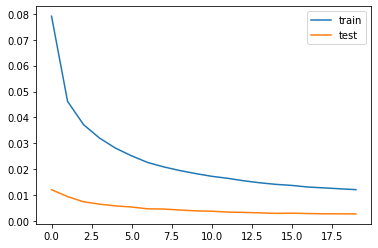

In [105]:
plt.plot(historyRnn.history['loss'], label='train')
plt.plot(historyRnn.history['val_loss'], label='test')
plt.legend()

Test RMSE: 4.145
Test MSE: 17.177
Test MAE: 2.535


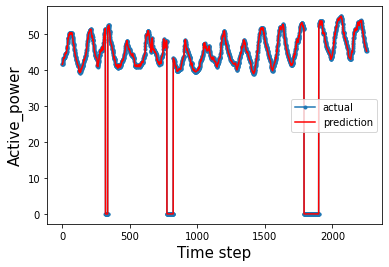

In [106]:
inv_y_r, rmse, mse, mae = metrics(modelRnn)

aa=[x for x in range(inv_y_r.shape[0])]
plt.plot(aa, inv_y_r[:inv_y_r.shape[0]], marker='.', label="actual")
plt.plot(aa, inv_y_r[:inv_y_r.shape[0]], 'r', label="prediction")
plt.ylabel('Active_power', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=10)
plt.show()